## Imports





In [ ]:
!pip install sentence_transformers
!pip install torch_geometric

In [ ]:
from dataset_dataloader import IMCAG, GraphDataLoader
from GCN import GCN
from sklearn import metrics
import warnings

from tqdm.auto import tqdm
import os
import torch
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")

## Functions

In [ ]:
def dataset_with_cwe(cwe=190):

    def pre_filter(data):
      if data.cwe == cwe:
        return 1
      return 0

    dataset = IMCAG('data/', pre_filter=pre_filter)
    dataset = dataset.shuffle()
    
    os.remove('/content/data/processed/data.pt')
    return dataset

In [ ]:
def test(report_dict=True):
    model.eval()
    loss_sum, acc_sum = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader)):
            data = data.to(device)
            out = model(data)

            loss = criterion(out, data.y)
            loss_sum += loss.item() * len(data)

            pred = out.argmax(dim=1)
            y_true.append(data.y)
            y_pred.append(pred)
            acc_sum += int((pred == data.y).sum())

    y_true, y_pred = torch.hstack(y_true).to('cpu'), torch.hstack(y_pred).to('cpu')
    report = metrics.classification_report(y_true, y_pred, output_dict=report_dict)
    cm = confusion_matrix(y_true, y_pred)
    return loss_sum / len(test_loader.sampler), acc_sum / len(test_loader.sampler), report, cm

## Load pretrained model

In [ ]:
if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"

device = torch.device(dev)

In [ ]:
state = torch.load('GCN_10epochs.pt')
model = GCN()
model.load_state_dict(state['state_dict'])
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()

## Test

In [ ]:
top20_cwe = [190, 191, 129, 89, 369, 789, 400, 113, 197, 80, 134, 36, 15, 23, 643, 470, 606, 90, 78, 319]

In [ ]:
reports = {}

In [ ]:
for cwe in tqdm(top20_cwe):
  dataset = dataset_with_cwe(cwe)
  test_loader = GraphDataLoader(dataset, batch_size=32, shuffle=False, pin_memory=torch.cuda.is_available())
  loss, accuracy, report = test()
  reports[f'{cwe}'] = report

In [ ]:
recall = []
keys = []
for key in reports.keys():
    keys.append(key)
    recall.append(reports[key]['1']['recall'])

In [ ]:
df = pd.DataFrame(data=recall, index=keys, columns=['Recall'])

In [ ]:
df.sort_values(by=['Recall'])

,Recall
134,0.926263
113,0.935354
369,0.943465
606,0.950000
78,0.951515
191,0.951786
190,0.953175
80,0.953535
129,0.955125
643,0.962121


### 50/50

In [ ]:
dataset_0 = dataset_with_cwe(0)
dataset_0 = dataset_0[:6300]
dataset_190 = dataset_with_cwe(190)
dataset = torch.utils.data.ConcatDataset([dataset_190, dataset_0])

In [ ]:
test_loader = GraphDataLoader(dataset, batch_size=128, shuffle=False, pin_memory=torch.cuda.is_available())
loss, accuracy, report, cm = test(False)

  0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6300
           1       0.89      0.95      0.92      6300

    accuracy                           0.92     12600
   macro avg       0.92      0.92      0.92     12600
weighted avg       0.92      0.92      0.92     12600



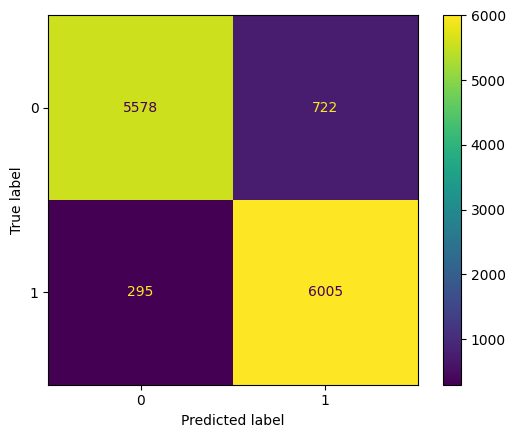

In [ ]:
cm_display = ConfusionMatrixDisplay(cm).plot()